In [1]:
import numpy as np 
import pandas as pd 
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt

In [2]:
movies = pd.read_csv("movies.csv") # contains movies and their attributes
ratings = pd.read_csv("ratings.csv") # contains ratings of users 

In [3]:
movies.shape

(9125, 22)

In [23]:
inertias = []
for k in range(2,100):
    kmodes = KModes(n_clusters = k, init = "Huang", n_init=2, random_state=42)
    kmodes.fit(movies.iloc[:,2:])
    inertias.append(kmodes.cost_) # sum of all dissimilarities between datapoints and clusters for every k 

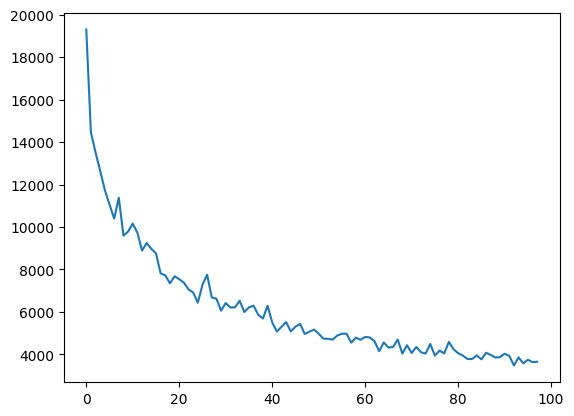

In [75]:
plt.plot(inertias) # looks like 45 clusters has an acceptable low cost with decreasing reduction after that point

In [4]:
k = 45
kmodes = KModes(n_clusters=k, init="Huang", n_init=10, random_state=42)
kmodes.fit(movies.iloc[:,2:])

KModes(init='Huang', n_clusters=45, random_state=42)

In [79]:
ratings.head(6)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151


In [80]:
movie_avgrating = pd.DataFrame(ratings.groupby("movieId")["rating"].mean()) # mean of ratings column for every movie id

In [81]:
user_code=198 # example user: we want to recommend movies to this specific user 

In [83]:
# extracting rows of ratings dataframe where user_code has rated
user_ratings_df = ratings[ratings["userId"] == user_code]

movies_rated = user_ratings_df["movieId"].tolist() # movie IDs the user has rated
user_ratings = user_ratings_df["rating"].tolist() # ratings of these movies by user

In [84]:
movies["ClusterID"] = kmodes.labels_ # adding ClusterID column to the movies dataframe 

In [85]:
user_clusters = pd.merge(user_ratings_df, movies[["movieId", "ClusterID"]], on = "movieId", how="left")

user_clusters = user_clusters["ClusterID"].tolist()

In [86]:
id_rating_cluster = pd.DataFrame({
    "Movie ID" : movies_rated,
    "Rating" : user_ratings,
    "Cluster of movie": user_clusters
})

In [87]:
cluster_ratings = pd.DataFrame(id_rating_cluster.groupby("Cluster of movie")["Rating"].mean().reset_index())
cluster_ratings = cluster_ratings[cluster_ratings["Rating"] >= 3.5] # keeping only ratings >= 3.5

In [88]:
# Merging dataframes to create a dataframe that contains -ALL- movie IDs, their avg rating,
# and the ClusterID they belong to. 
movies_rat_cluster = pd.merge(movie_avgrating, movies[["movieId","ClusterID"]], on="movieId", how="left")

In [89]:
# SORTING by ClusterID and rating: basically sorting rating by groups of ClusterID
movies_rat_cluster_sort = movies_rat_cluster.sort_values(by = ["ClusterID", "rating"])

# movies_rat_cluster_sort contains all movie Ids, their average rating, and their cluster ID
# id_rating_cluster contains the movie ID that the user has rated, their average rating, and their cluster
# cluster ratings contains the cluster that user has rated and their average rating above 3.5

In [90]:
rows = [] # list of dictionaries that will contain the cluster, top1movie id and top2movie id
for i in cluster_ratings["Cluster of movie"]: # iterating over the cluster IDs that the user likes

    # for every cluster ID that the user likes, we find the top 2 highest rated movies in that cluster, that the user HAS NOT rated yet.
    
    subset = movies_rat_cluster_sort[movies_rat_cluster_sort["ClusterID"] == i] # we filter the movies with the clusters IDs that the user likes
    subset = subset[~subset["movieId"].isin(id_rating_cluster["Movie ID"])] # we filter the movies that the user has NOT rated

    # Robustness check: subset may not include 2 movies that could lead to an indexing error.
    if len(subset)>=2:
        top1 = subset["movieId"].iloc[-1]
        top2 = subset["movieId"].iloc[-2]
    elif len(subset) == 1:
        top1 = subset["movieId"].iloc[-1]
        top2 = None
    else:
        top1 = None
        top2 = None
        
    rows.append({
        "Cluster": i,
        "top1movie": top1,
        "top2movie": top2
    }) # this row contains the top 1 and top 2 rated movie (based on average rating) that the cluster ID that the user likes has.
    
movie_recom = pd.DataFrame(rows, columns=["Cluster", "top1movie", "top2movie"]) #adding all rows to a dataframe

In [91]:
print("Movie Recommendations for user with code: ", user_code )
for i in movie_recom["top1movie"]: #iterating over movie IDs that have the no. 1 avg rating in that cluster and have NOT been rated by the user
    print(movies["title"][movies["movieId"] == i ] )

Movie Recommendations for user with code:  198
8983    Almost Normal (2005)
Name: title, dtype: object
8750    Mei and the Kittenbus (2002)
Name: title, dtype: object
8574    Centenarian Who Climbed Out the Window and Van...
Name: title, dtype: object
9117    The Last Brickmaker in America (2001)
Name: title, dtype: object
8675    Helter Skelter (1976)
Name: title, dtype: object
9079    Ice Age: The Great Egg-Scapade (2016)
Name: title, dtype: object
8988    The Biggest Fan (2002)
Name: title, dtype: object
8987    The Big Gay Musical (2009)
Name: title, dtype: object
4300    Looney; Looney; Looney Bugs Bunny Movie; The (...
Name: title, dtype: object
8801    The Pacific (2010)
Name: title, dtype: object
8208    Burn Up! (1991)
Name: title, dtype: object
7475    Gentlemen of Fortune (Dzhentlmeny udachi) (1972)
Name: title, dtype: object
9122    The Beatles: Eight Days a Week - The Touring Y...
Name: title, dtype: object
5503    Enemy Below; The (1957)
Name: title, dtype: object
9065   